<a href="https://colab.research.google.com/github/jeet1912/ms/blob/main/ds677/assignments/DS677Week9HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### My kaggle id: abhijeetsahdev

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import h5py
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(33)
tf.random.set_seed(33)

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())
except ValueError:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU/GPU')

Running on TPU  


### Preprocessing

In [ ]:
def loadhdf5Data(file_path):
  with h5py.File(file_path, 'r') as hdf:
    H_Re = tf.convert_to_tensor(hdf['H_Re'][:], dtype=tf.float32)
    H_Im = tf.convert_to_tensor(hdf['H_Im'][:], dtype=tf.float32)
    SNR = tf.convert_to_tensor(hdf['SNR'][:], dtype=tf.float32)
    if 'Pos' in hdf:
      Pos = tf.convert_to_tensor(hdf['Pos'][:], dtype=tf.float32)
      return tf.concat([H_Re, H_Im], axis=-1), SNR, Pos
    return tf.concat([H_Re, H_Im], axis=-1), SNR, tf.zeros((1, 3))  # Placeholder if no Pos data

def preprocess(file_path, use_tpu=False):
  if use_tpu:
    with strategy.scope():
      return loadhdf5Data(file_path)
  else:
      return loadhdf5Data(file_path)

In [ ]:
labelledPath = "/content/drive/MyDrive/ds677/week9/labelled_data/"
labelled_data = []
with strategy.scope():
  for i in range(1, 9):
    file_path = f"{labelledPath}file_{i}.hdf5"
    data, snr, pos = preprocess(file_path, use_tpu=False)
    labelled_data.append((data, snr, pos))

    # Concatenate data
    H_labelled, SNR_labelled, Pos_labelled = zip(*labelled_data)
    H_labelled = tf.concat(H_labelled, axis=0)
    SNR_labelled = tf.concat(SNR_labelled, axis=0)
    Pos_labelled = tf.concat(Pos_labelled, axis=0)

    H_labelled_np = H_labelled.numpy()
    Pos_labelled_np = Pos_labelled.numpy()

    # Split labelled data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(H_labelled_np, Pos_labelled_np, test_size=0.3, random_state=33)

    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

# Unlabelled data
unlabelled_path = "/content/drive/MyDrive/ds677/week9/unlabelled_data/"
unlabelled_data = []
with strategy.scope():
  for i in range(1, 65):
    file_path = f"{unlabelled_path}file_{i}.hdf5"
    data, snr, _ = preprocess(file_path, use_tpu=True)
    unlabelled_data.append((data, snr))

  H_unlabelled, SNR_unlabelled = zip(*unlabelled_data)
  H_unlabelled = tf.concat(H_unlabelled, axis=0)


It would be an act of tremendous/unparalleled/unprecedented generosity if we could store processed outputs at each stage of a DL pipeline.

### Self Supervised Model

In [ ]:
with strategy.scope():
  def buildSelfSupervisedModel(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='linear'),
        layers.Reshape(input_shape)
    ])
    return model

  # changed LR to 0.0008 from 0.0005
  lr = 0.0008
  optimizer = Adam(learning_rate=lr)
  loss = 'mse'

  self_supervised_model = buildSelfSupervisedModel(H_unlabelled.shape[1:])
  self_supervised_model.compile(optimizer=optimizer, loss=loss)
  self_supervised_model.fit(H_unlabelled, H_unlabelled, epochs=50, batch_size=128*8, validation_split=0.13)

Epoch 1/50
31/31 [==============================] - 204s 5s/step - loss: 0.0403 - val_loss: 0.0238
Epoch 2/50
31/31 [==============================] - 122s 4s/step - loss: 0.0277 - val_loss: 0.0188
Epoch 3/50
31/31 [==============================] - 121s 4s/step - loss: 0.0220 - val_loss: 0.0151
Epoch 4/50
31/31 [==============================] - 119s 4s/step - loss: 0.0176 - val_loss: 0.0132
Epoch 5/50
31/31 [==============================] - 120s 4s/step - loss: 0.0155 - val_loss: 0.0121
Epoch 6/50
31/31 [==============================] - 120s 4s/step - loss: 0.0143 - val_loss: 0.0111
Epoch 7/50
31/31 [==============================] - 121s 4s/step - loss: 0.0135 - val_loss: 0.0105
Epoch 8/50
31/31 [==============================] - 121s 4s/step - loss: 0.0127 - val_loss: 0.0101
Epoch 9/50
31/31 [==============================] - 127s 4s/step - loss: 0.0122 - val_loss: 0.0099
Epoch 10/50
31/31 [==============================] - 120s 4s/step - loss: 0.0117 - val_loss: 0.0094
Epoch 11/

Wish we could plot loss and val_loss right here and append the System Ram and Disk plots from Resources. The above image was obtained with |validation set| = 0.1 * H_unlabeled.
// unlabelled or labeled.  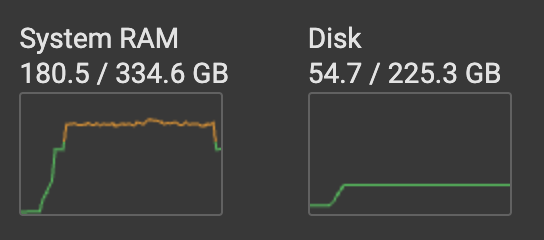


### Supervised Model

In [ ]:
with strategy.scope():
  def buildSupervisedModel(input_shape, output_shape):
      base_model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
      ])

      model = models.Sequential([
        base_model,
        layers.Dense(64, activation='relu'),
        layers.Dense(output_shape)
    ])
      return model

  # Extracting features from self-supervised model
  features = self_supervised_model.predict(X_train)

  lr = 0.0008
  optimizer = Adam(learning_rate=lr)

  supervised_model = buildSupervisedModel(features.shape[1:], y_train.shape[1])
  supervised_model.compile(optimizer=optimizer, loss='mse')

  # Training the supervised model
  history = supervised_model.fit(features, y_train, validation_data=(self_supervised_model.predict(X_val), y_val), epochs=1000, batch_size=128*8)

39/39 [==============================] - 33s 862ms/step
Epoch 1/1000
3/3 [==============================] - 50s 16s/step - loss: 130903.4375 - val_loss: 121850.1562
Epoch 2/1000
3/3 [==============================] - 8s 3s/step - loss: 113769.3516 - val_loss: 104990.6406
Epoch 3/1000
3/3 [==============================] - 8s 4s/step - loss: 102824.8516 - val_loss: 99644.0625
Epoch 4/1000
3/3 [==============================] - 8s 3s/step - loss: 94954.0781 - val_loss: 90841.0703
Epoch 5/1000
3/3 [==============================] - 9s 4s/step - loss: 87141.0703 - val_loss: 82778.1172
Epoch 6/1000
3/3 [==============================] - 9s 4s/step - loss: 77896.0391 - val_loss: 72144.6250
Epoch 7/1000
3/3 [==============================] - 8s 3s/step - loss: 68479.3281 - val_loss: 62023.3672
Epoch 8/1000
3/3 [==============================] - 8s 3s/step - loss: 57380.2539 - val_loss: 49959.4688
Epoch 9/1000
3/3 [==============================] - 8s 3s/step - loss: 45661.8008 - val_loss: 380

### Testing

In [ ]:
with strategy.scope():
  test_path = "/content/drive/MyDrive/ds677/week9/test/"
  data, _, true_positions = preprocess(f"{test_path}/file_{str(1)}.hdf5", use_tpu=True)

  # Predict using the trained model
  test_features = self_supervised_model.predict(data)
  predictions = supervised_model.predict(test_features)

# Create CSV
df = pd.DataFrame({
    'id': range(0, 883),
    'x': predictions[:, 0],
    'y': predictions[:, 1],
    'z': predictions[:, 2]
})

mae3 = np.mean(np.abs(predictions - true_positions))
print(f"Mean Absolute Error with LR = 0.0008  and VS = 0.13 ratio : {mae3}")

df.to_csv('/content/drive/MyDrive/ds677/week9/predictions3.csv', index=False)

28/28 [==============================] - 11s 149ms/step
Mean Absolute Error with LR = 0.0008  and VS = 0.13 ratio : 305.452880859375


The following code has been separated from the above cell for documentation purposes only.

In [ ]:
mae = np.mean(np.abs(predictions - true_positions))
print(f"Mean Absolute Error: {mae}")

df.to_csv('/content/drive/MyDrive/ds677/week9/predictions2.csv', index=False)

28/28 [==============================] - 8s 145ms/step
Mean Absolute Error: 317.5281677246094


It improved on the previous score approved on kaggle. Moving on, I'll set validation set ratio to 0.5 and lr to 0.0008 with validation set ratio set to 0.13 for the final tuning. This has been depicted in the first cell under Testing.

The following is the mae for my only submission on Kaggle.

In [ ]:
import pandas as pd
import numpy as np

test_path = "/content/drive/MyDrive/ds677/week9/test/"
data, _, true_positions = preprocess(f"{test_path}/file_{str(1)}.hdf5", use_tpu=True)
pred1 = pd.read_csv('/content/drive/MyDrive/ds677/week9/predictions.csv')
pred1.drop(columns=['id'], inplace=True)
pred1 = pred1.to_numpy()
mae1 = np.mean(np.abs(pred1 - true_positions))


In [ ]:
print(f"Mean Absolute Error: {mae1}")

Mean Absolute Error: 313.4657287597656


### To Kaggle

In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=8d2c06986fe80110a9fc62e38268b1dd97b6e2872021ee9f6a5769aaf65c9df0
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
!chmod 600 /content/drive/MyDrive/kaggle.json
!ls -la /content/drive/MyDrive/kaggle.json

-rw------- 1 root root 70 Nov 12 15:59 /content/drive/MyDrive/kaggle.json


In [ ]:
!kaggle competitions submit -c ds-677-deep-learning-week-9-hw-1-fall-2024 -f /content/drive/MyDrive/ds677/week9/predictions3.csv -m "submission_5"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions submit -c ds-677-deep-learning-week-9-hw-1-fall-2024 -f /content/drive/MyDrive/ds677/week9/predictions3.csv -m "submission_6"

100% 29.1k/29.1k [00:00<00:00, 34.7kB/s]
Successfully submitted to DS677 Deep Learning Week9 HW1 - Fall 2024